# NLSQ 2D Gaussian Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dipolar-Quantum-Gases/nlsq/blob/main/examples/NLSQ%202D%20Gaussian%20Demo.ipynb)

## Installing and Importing

Make sure your runtime type is set to GPU rather than CPU. Then we install NLSQ with pip

In [1]:
!pip install nlsq

Import NLSQ before importing JAX since we need NLSQ to set all the JAX computation to use 64 rather than 32 bit arrays.

In [2]:
import jax.numpy as jnp

from nlsq import CurveFit

Now let's define a 2D Gaussian using jax.numpy. You can construct function just like numpy with a few small caveats (see **).

In [3]:
def rotate_coordinates2D(coords, theta):
    R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])

    shape = coords[0].shape
    coords = jnp.stack([coord.flatten() for coord in coords])
    rcoords = R @ coords
    return [jnp.reshape(coord, shape) for coord in rcoords]


def gaussian2d(coords, n0, x0, y0, sigma_x, sigma_y, theta, offset):
    coords = [coords[0] - x0, coords[1] - y0]  # translate first
    X, Y = rotate_coordinates2D(coords, theta)
    density = n0 * jnp.exp(-0.5 * (X**2 / sigma_x**2 + Y**2 / sigma_y**2))
    return density + offset

Using the function we just created, we'll simulate some synthetic fit data and show what it looks like.

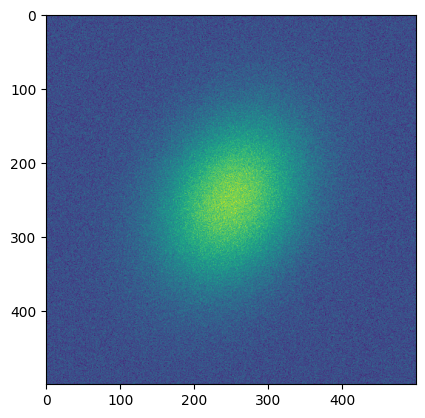

In [4]:
import time

import matplotlib.pyplot as plt
import numpy as np


def get_coordinates(width, height):
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    X, Y = np.meshgrid(x, y)
    return X, Y


def get_gaussian_parameters(length):
    n0 = 1
    x0 = length / 2
    y0 = length / 2
    sigx = length / 6
    sigy = length / 8
    theta = np.pi / 3

    offset = 0.1 * n0
    params = [n0, x0, y0, sigx, sigy, theta, offset]
    return params


length = 500
XY_tuple = get_coordinates(length, length)

params = get_gaussian_parameters(length)
zdata = gaussian2d(XY_tuple, *params)
zdata += np.random.normal(0, 0.1, size=(length, length))

plt.imshow(zdata)
plt.show()

Now we initialize the NLSQ CurveFit object and then fit our synthetic data 100 times with a different random seed for each fit.

In [5]:
from scipy.optimize import curve_fit


def get_random_float(low, high):
    delta = high - low
    return low + delta * np.random.random()


flat_data = zdata.flatten()
flat_XY_tuple = [coord.flatten() for coord in XY_tuple]
jcf = CurveFit()

loop = 100
times = []
stimes = []
for i in range(loop):
    print(i, "of", loop)
    seed = [val * get_random_float(0.9, 1.2) for val in params]
    st = time.time()
    popt, pcov = jcf.curve_fit(gaussian2d, flat_XY_tuple, flat_data, p0=seed)
    times.append(time.time() - st)

popt2, pcov2 = curve_fit(gaussian2d, flat_XY_tuple, flat_data, p0=seed)

0 of 100


E0924 18:09:25.488634   92461 pjrt_stream_executor_client.cc:3314] Execution of replica 0 failed: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error


XlaRuntimeError: INTERNAL: jaxlib/gpu/solver_handle_pool.cc:37: operation gpusolverDnCreate(&handle) failed: cuSolver internal error

Let's see how fast these fits were done and how they compare to SciPy in accuracy.

In [ ]:
print("Average fit time", np.mean(times[1:]))
print("NLSQ parameters", popt)
print("SciPy parameters", popt2)

plt.figure()
plt.plot(times[1:])
plt.xlabel("Fit Number")
plt.ylabel("Fit Speed (seconds)")
plt.show()

ooo so speedy

In [ ]:
# jcf = CurveFit(flength=length**2)